In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : [],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_e_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 923)
(734160, 1)
validation
(101248, 923)
(101248, 1)
test
(100432, 923)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 923)]             0         


 dense (Dense)               (None, 1024)              946176    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1635329 (6.24 MB)


Trainable params: 1635329 (6.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:36 - loss: 0.1624 - STD: 1.8600e-04 - MAE: 0.3898

 4/74 [>.............................] - ETA: 1s - loss: 0.0581 - STD: 4.2038e-04 - MAE: 0.1834  

 7/74 [=>............................] - ETA: 1s - loss: 0.0495 - STD: 2.8723e-04 - MAE: 0.1740

10/74 [===>..........................] - ETA: 1s - loss: 0.0460 - STD: 2.1208e-04 - MAE: 0.1700

13/74 [====>.........................] - ETA: 1s - loss: 0.0415 - STD: 1.7986e-04 - MAE: 0.1589

16/74 [=====>........................] - ETA: 1s - loss: 0.0364 - STD: 1.6777e-04 - MAE: 0.1418

19/74 [======>.......................] - ETA: 1s - loss: 0.0330 - STD: 1.6115e-04 - MAE: 0.1352

22/74 [=======>......................] - ETA: 1s - loss: 0.0309 - STD: 1.5436e-04 - MAE: 0.1332

25/74 [=========>....................] - ETA: 1s - loss: 0.0289 - STD: 1.4680e-04 - MAE: 0.1284

28/74 [==========>...................] - ETA: 1s - loss: 0.0271 - STD: 1.3906e-04 - MAE: 0.1215

31/74 [===========>..................] - ETA: 0s - loss: 0.0258 - STD: 1.3218e-04 - MAE: 0.1159

34/74 [============>.................] - ETA: 0s - loss: 0.0248 - STD: 1.2655e-04 - MAE: 0.1111

37/74 [==============>...............] - ETA: 0s - loss: 0.0237 - STD: 1.2237e-04 - MAE: 0.1071

40/74 [===============>..............] - ETA: 0s - loss: 0.0229 - STD: 1.1953e-04 - MAE: 0.1046

43/74 [================>.............] - ETA: 0s - loss: 0.0222 - STD: 1.1754e-04 - MAE: 0.1032

46/74 [=================>............] - ETA: 0s - loss: 0.0215 - STD: 1.1613e-04 - MAE: 0.1017

49/74 [==================>...........] - ETA: 0s - loss: 0.0210 - STD: 1.1507e-04 - MAE: 0.0998

52/74 [====================>.........] - ETA: 0s - loss: 0.0204 - STD: 1.1433e-04 - MAE: 0.0977

55/74 [=====================>........] - ETA: 0s - loss: 0.0201 - STD: 1.1400e-04 - MAE: 0.0958

58/74 [======================>.......] - ETA: 0s - loss: 0.0197 - STD: 1.1433e-04 - MAE: 0.0942

61/74 [=======================>......] - ETA: 0s - loss: 0.0193 - STD: 1.1523e-04 - MAE: 0.0931

64/74 [========================>.....] - ETA: 0s - loss: 0.0190 - STD: 1.1670e-04 - MAE: 0.0923

67/74 [==========================>...] - ETA: 0s - loss: 0.0186 - STD: 1.1843e-04 - MAE: 0.0914

70/74 [===========================>..] - ETA: 0s - loss: 0.0183 - STD: 1.2049e-04 - MAE: 0.0904

73/74 [============================>.] - ETA: 0s - loss: 0.0181 - STD: 1.2294e-04 - MAE: 0.0894

74/74 [==============================] - 4s 40ms/step - loss: 0.0180 - STD: 1.2382e-04 - MAE: 0.0891 - val_loss: 0.0146 - val_STD: 1.3847e-04 - val_MAE: 0.0707


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0120 - STD: 1.9467e-04 - MAE: 0.0664

 4/74 [>.............................] - ETA: 1s - loss: 0.0121 - STD: 2.0579e-04 - MAE: 0.0677

 7/74 [=>............................] - ETA: 1s - loss: 0.0120 - STD: 2.1805e-04 - MAE: 0.0690

10/74 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 2.2963e-04 - MAE: 0.0698

13/74 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 2.4142e-04 - MAE: 0.0700

16/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 2.5398e-04 - MAE: 0.0698

19/74 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 2.6785e-04 - MAE: 0.0696

22/74 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 2.8368e-04 - MAE: 0.0694

25/74 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 3.0119e-04 - MAE: 0.0694

28/74 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 3.2071e-04 - MAE: 0.0694

31/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 3.4271e-04 - MAE: 0.0695

34/74 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 3.6707e-04 - MAE: 0.0694

37/74 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 3.9381e-04 - MAE: 0.0694

40/74 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 4.2378e-04 - MAE: 0.0693

43/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 4.5750e-04 - MAE: 0.0692

46/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 4.9577e-04 - MAE: 0.0691

49/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 5.3985e-04 - MAE: 0.0692

52/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 5.8992e-04 - MAE: 0.0691

55/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 6.4697e-04 - MAE: 0.0690

58/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 7.1215e-04 - MAE: 0.0689

60/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 7.6192e-04 - MAE: 0.0689

63/74 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 8.4782e-04 - MAE: 0.0689

66/74 [=========================>....] - ETA: 0s - loss: 0.0119 - STD: 9.4894e-04 - MAE: 0.0689

69/74 [==========================>...] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0688    

72/74 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0687

74/74 [==============================] - 2s 27ms/step - loss: 0.0118 - STD: 0.0013 - MAE: 0.0686 - val_loss: 0.0135 - val_STD: 0.0041 - val_MAE: 0.0700


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0114 - STD: 0.0059 - MAE: 0.0663

 4/74 [>.............................] - ETA: 1s - loss: 0.0111 - STD: 0.0066 - MAE: 0.0663

 7/74 [=>............................] - ETA: 1s - loss: 0.0109 - STD: 0.0074 - MAE: 0.0658

10/74 [===>..........................] - ETA: 1s - loss: 0.0108 - STD: 0.0083 - MAE: 0.0652

13/74 [====>.........................] - ETA: 1s - loss: 0.0107 - STD: 0.0095 - MAE: 0.0647

16/74 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 0.0108 - MAE: 0.0640

19/74 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 0.0123 - MAE: 0.0632

22/74 [=======>......................] - ETA: 1s - loss: 0.0100 - STD: 0.0141 - MAE: 0.0624

25/74 [=========>....................] - ETA: 1s - loss: 0.0098 - STD: 0.0162 - MAE: 0.0616

28/74 [==========>...................] - ETA: 0s - loss: 0.0096 - STD: 0.0185 - MAE: 0.0606

31/74 [===========>..................] - ETA: 0s - loss: 0.0093 - STD: 0.0211 - MAE: 0.0596

34/74 [============>.................] - ETA: 0s - loss: 0.0090 - STD: 0.0239 - MAE: 0.0586

37/74 [==============>...............] - ETA: 0s - loss: 0.0087 - STD: 0.0268 - MAE: 0.0575

40/74 [===============>..............] - ETA: 0s - loss: 0.0084 - STD: 0.0298 - MAE: 0.0564

44/74 [================>.............] - ETA: 0s - loss: 0.0081 - STD: 0.0338 - MAE: 0.0551

47/74 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0368 - MAE: 0.0541

50/74 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0395 - MAE: 0.0532

53/74 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0424 - MAE: 0.0523

56/74 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0449 - MAE: 0.0515

59/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0473 - MAE: 0.0508

62/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0494 - MAE: 0.0500

65/74 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0513 - MAE: 0.0494

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0488

71/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0482

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0477

74/74 [==============================] - 2s 25ms/step - loss: 0.0061 - STD: 0.0563 - MAE: 0.0477 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0336


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0860 - MAE: 0.0343

 4/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0350

 7/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0915 - MAE: 0.0346

10/74 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0929 - MAE: 0.0347

12/74 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0345

15/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0938 - MAE: 0.0344

17/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0343

20/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0940 - MAE: 0.0342

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0942 - MAE: 0.0341

26/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0942 - MAE: 0.0340

29/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0942 - MAE: 0.0338

32/74 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0337

35/74 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0336

38/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0335

41/74 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0334

44/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0333

47/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0332

50/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0331

53/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0330

56/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0329

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0328

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0327

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0326

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0325

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0954 - MAE: 0.0324

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0956 - MAE: 0.0323

74/74 [==============================] - 2s 28ms/step - loss: 0.0024 - STD: 0.0956 - MAE: 0.0323 - val_loss: 0.0025 - val_STD: 0.0697 - val_MAE: 0.0295


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0300

 4/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0965 - MAE: 0.0298

 7/74 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0299

10/74 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0299

13/74 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0974 - MAE: 0.0299

16/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0299

19/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0299

22/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0299

25/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0975 - MAE: 0.0298

28/74 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0297

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0297

33/74 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0296

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0296

39/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0296

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0295

45/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0295

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0295

51/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0295

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0294

57/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0294

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0293

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0293

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0293

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0981 - MAE: 0.0292

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0292

74/74 [==============================] - 2s 27ms/step - loss: 0.0020 - STD: 0.0982 - MAE: 0.0292 - val_loss: 0.0023 - val_STD: 0.0746 - val_MAE: 0.0303


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0298

 3/74 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0292

 6/74 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0288

11/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0287

14/74 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

17/74 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

19/74 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0287

22/74 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0287

25/74 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0287

28/74 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0287

31/74 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0288

34/74 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0290

40/74 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0289

46/74 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0289

48/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0288

51/74 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0288

54/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0287

57/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0285

74/74 [==============================] - 2s 26ms/step - loss: 0.0019 - STD: 0.0994 - MAE: 0.0285 - val_loss: 0.0021 - val_STD: 0.0754 - val_MAE: 0.0273


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0276

 4/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0277

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0276

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0278

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0278

16/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0278

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0278

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0277

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0277

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0277

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0277

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0277

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0277

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0277

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0276

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0276

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0276

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0276

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0275

74/74 [==============================] - 2s 27ms/step - loss: 0.0018 - STD: 0.1002 - MAE: 0.0275 - val_loss: 0.0021 - val_STD: 0.0742 - val_MAE: 0.0270


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0977 - MAE: 0.0285

 3/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0280

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0281

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0276

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0276

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0275

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0276

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0275

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

48/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0283

51/74 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

54/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

57/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0282

74/74 [==============================] - 2s 27ms/step - loss: 0.0019 - STD: 0.1002 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0743 - val_MAE: 0.0265


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0962 - MAE: 0.0265

 3/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0272

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0272

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0271

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0271

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0272

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0272

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0273

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0273

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0273

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0272

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0272

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0272

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0272

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0272

74/74 [==============================] - 2s 27ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0760 - val_MAE: 0.0263


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0271

 3/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0274

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0274

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0274

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0275

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0276

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0276

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0276

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0275

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0275

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0275

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0274

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0274

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0271

74/74 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1008 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.0779 - val_MAE: 0.0265


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0266

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0267

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0268

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0268

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0268

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0268

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0267

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0267

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0267

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0267

30/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0266

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0266

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0266

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0266

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0266

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0266

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0266

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0266

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0265

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

74/74 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0790 - val_MAE: 0.0273


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0265

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0274

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0277

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0277

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0276

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0275

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

30/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0275

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0276

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0276

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0275

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0764 - val_MAE: 0.0259


Epoch 13/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0962 - MAE: 0.0260

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0265

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0267

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0266

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0265

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0265

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0265

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0265

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0265

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0265

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0265

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0264

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0264

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0264

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0264

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0262

74/74 [==============================] - 2s 28ms/step - loss: 0.0016 - STD: 0.1014 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0793 - val_MAE: 0.0267


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0265

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0263

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0263

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0261

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0261

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0261

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0261

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0262

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0262

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0262

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0799 - val_MAE: 0.0265


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0250

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0257

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0273

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

16/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0276

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

23/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

26/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

29/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

35/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0268

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0267

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0267

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0267

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0267

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0267

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0267

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

74/74 [==============================] - 2s 24ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0808 - val_MAE: 0.0276


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0258

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0261

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0260

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0259

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0261

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0260

20/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0260

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0260

26/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0260

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0260

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0260

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0260

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0260

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0259

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0805 - val_MAE: 0.0267


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0256

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0258

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0256

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0261

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0263

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0261

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0261

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0261

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0263

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262 - val_loss: 0.0020 - val_STD: 0.0826 - val_MAE: 0.0298


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1089 - MAE: 0.0271

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0257

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0256

26/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0258

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0258

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0259

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0259

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0259

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0260

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0260

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0790 - val_MAE: 0.0260


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1012 - MAE: 0.0251

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0266

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0264

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0263

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0261

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0261

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0260

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0261

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0258

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1019 - MAE: 0.0258 - val_loss: 0.0019 - val_STD: 0.0817 - val_MAE: 0.0286


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0253

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0254

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0261

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0261

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0260

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0260

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0791 - val_MAE: 0.0255


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0255

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0257

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0255

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0253

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0253

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0253

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0253

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0253

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0254

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0254

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0254

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0254

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0254

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0254

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0255

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0255

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0255

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0761 - val_MAE: 0.0259


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0967 - MAE: 0.0274

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0265

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0262

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0256

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0256

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0256

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0258

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

74/74 [==============================] - 2s 24ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259 - val_loss: 0.0019 - val_STD: 0.0767 - val_MAE: 0.0256


Epoch 23/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0929 - MAE: 0.0265

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.0991 - MAE: 0.0262

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.0993 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0273

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0268

20/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0267

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0266

26/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0264

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0263

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0262

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0261

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0261

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0260

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0259

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0259

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0258

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0258

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0258

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0257

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0257

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0781 - val_MAE: 0.0254


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0960 - MAE: 0.0252

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0253

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0253

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0252

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0251

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0251

18/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0251

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0251

24/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0251

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0251

30/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0251

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0252

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0253

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0253

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0253

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0253

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0252

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0252

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0252

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0252

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0255

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254 - val_loss: 0.0020 - val_STD: 0.0831 - val_MAE: 0.0293


Epoch 25/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0257

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0252

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0253

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0253

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0255

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0256

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0258

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0258

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0816 - val_MAE: 0.0271


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0249

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1013 - MAE: 0.0248

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0248

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0248

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0249

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0248

18/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0248

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0248

24/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0248

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0248

30/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0248

33/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0249

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0249

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0248

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0248

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0248

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0248

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0249

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0251

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0252

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0252

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0253

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0253 - val_loss: 0.0020 - val_STD: 0.0835 - val_MAE: 0.0294


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0252

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0253

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0257

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0257

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0257

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0255

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0254

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0254

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0253

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0253

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0253

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0252

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0251

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0251

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0251

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0251

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0252

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0252

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0252

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0828 - val_MAE: 0.0270


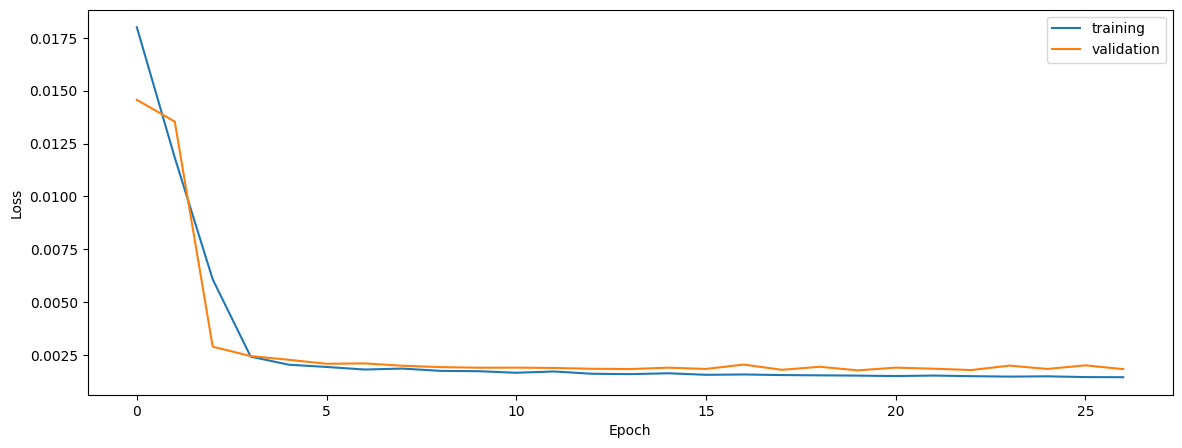

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9371051734335724
0.9370079939959678
0.9421261546894069


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.9352691678976303
0.9483475861904601
0.942688512527775


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.938162852802127
0.9478951743949681
0.9486225459163626


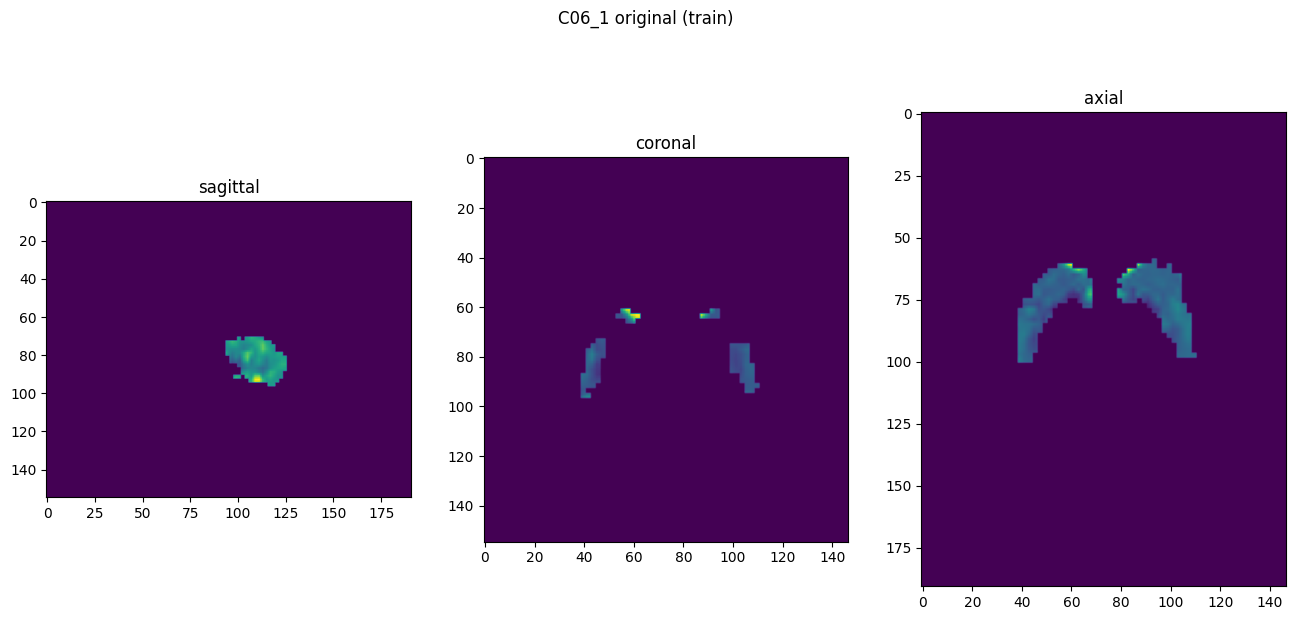

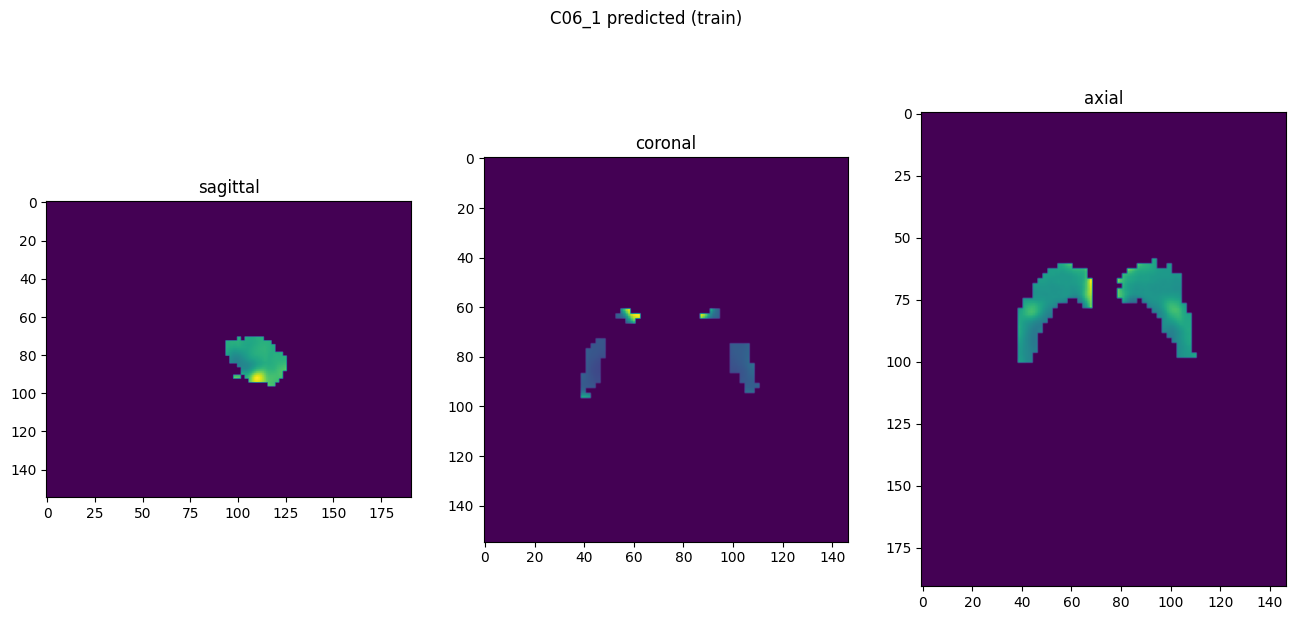

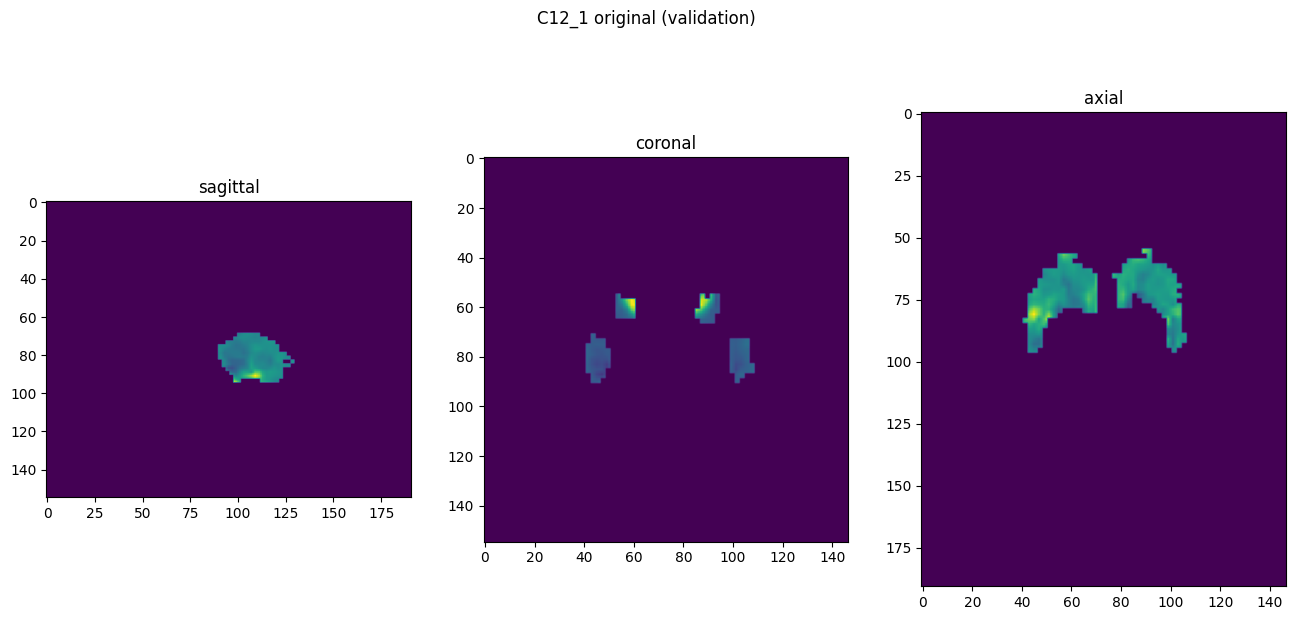

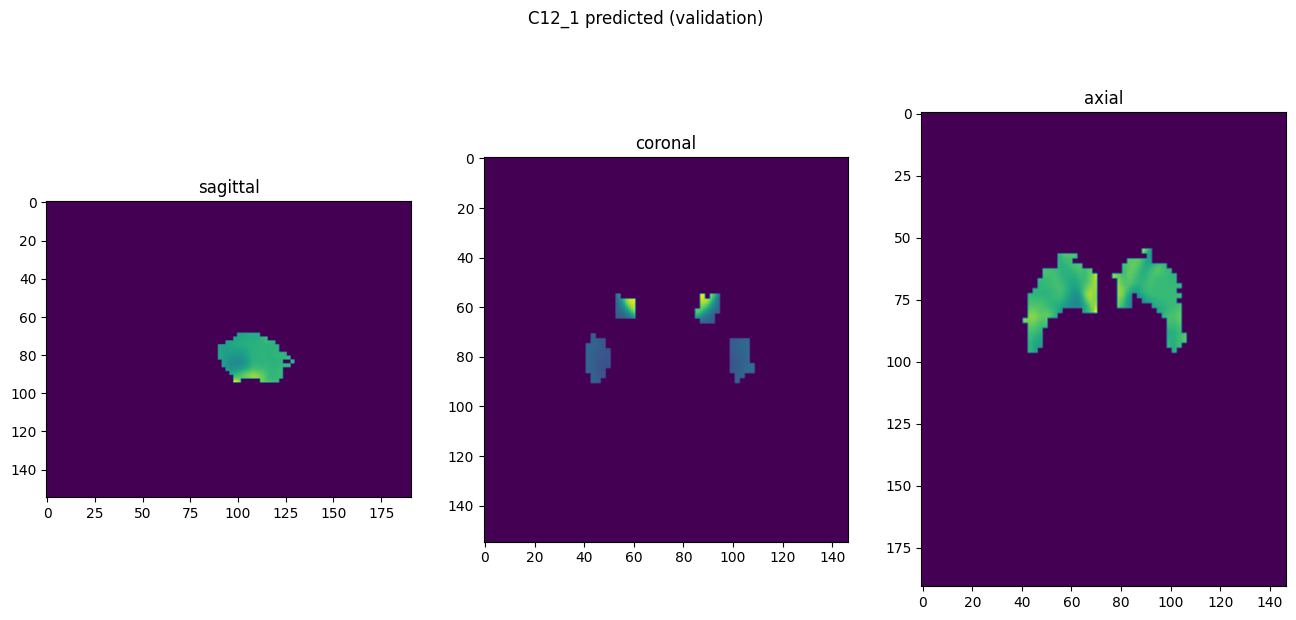

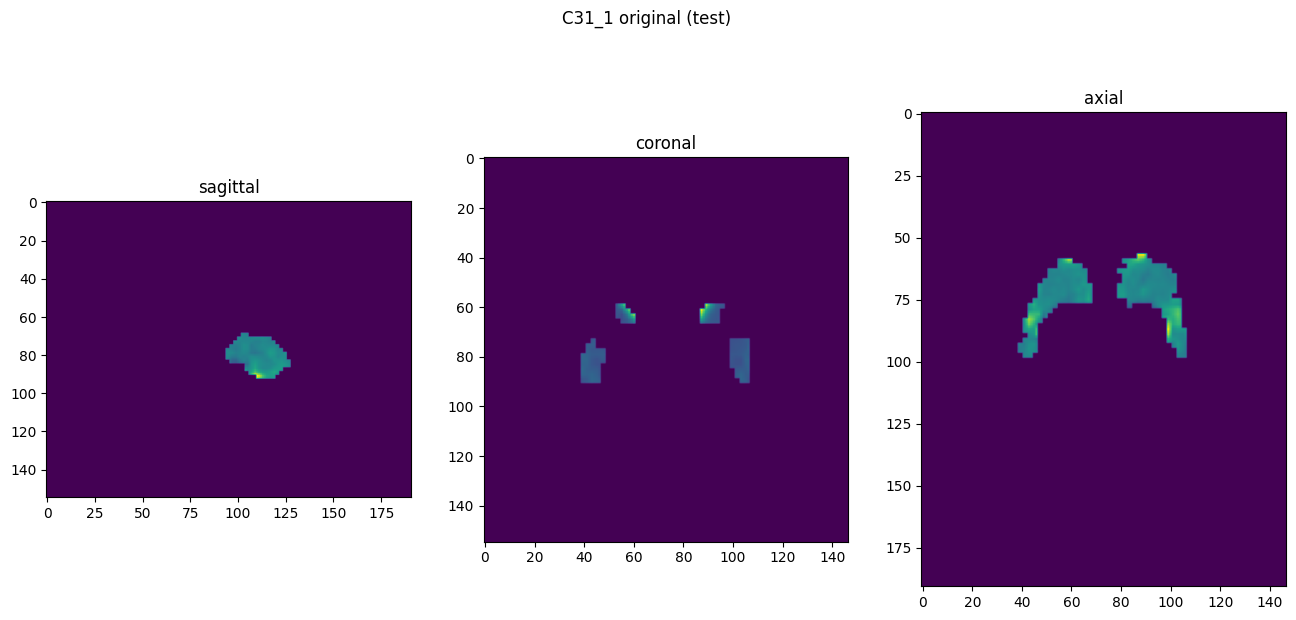

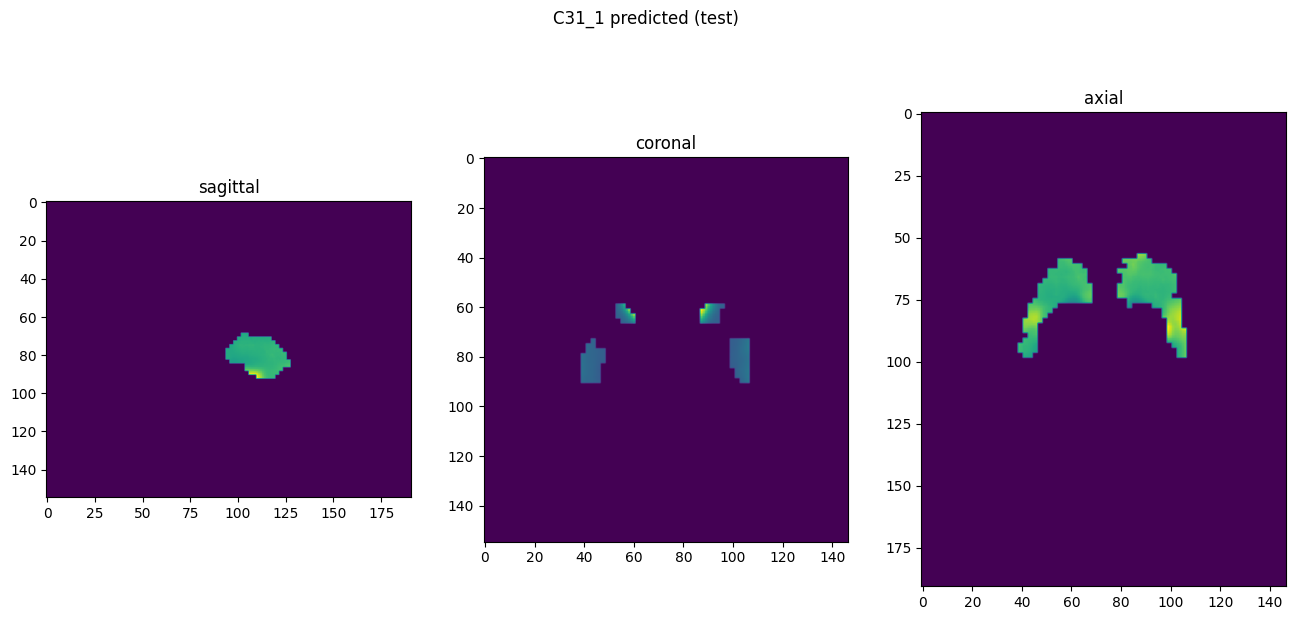

In [10]:
showResults(model, gen, threshold=None, background=False)